## Two Samples z-test for Proportions

## $z = \frac{\hat{p_1}-\hat{p_2}}{\sqrt{\hat{p} (1-\hat{p}) (\frac{1}{n_1} + \frac{1}{n_2})}} $
where

### $\hat{p_1} = \frac{x_1}{n_1}, \hat{p_2} = \frac{x_2}{n_2} $
### $\hat{p} = \frac{x_1 + x_2}{n_1 + n_2}$
$x_1, x_2$ - number of successes in group 1 and 2

$n_1, n_2$ - number of observations in group 1 and 2

In [6]:
# implementation from scratch
from math import sqrt
import scipy.stats as stats

def ztest_proportion_two_samples(xa, na, xb, nb, one_sided=True, verbose=False):
    pa = xa/na
    pb = xb/nb    

    p = (xa+xb)/(na+nb)
    denom = sqrt(p*(1-p)*(1/na+1/nb))
    
    z = (pa-pb)/denom
    p = 1-stats.norm.cdf(abs(z))
    p *= 2-one_sided # if not one_sided: p *= 2
    
    if verbose:
        print(xa, na, xb, nb)
        print('z-stat = {z}'.format(z=z))
        print('p-value = {p}'.format(p=p))

    return p

In [12]:
ztest_proportion_two_samples(7000, 200000, 7000, 200000, False, True)

7000 200000 7000 200000
z-stat = 0.0
p-value = 1.0


1.0

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import *

import statsmodels.stats.weightstats as wstats
%matplotlib inline

In [14]:
!cat experiment_stats.csv | head -3

variant,ord_value
1,0
0,0
cat: stdout: Broken pipe


In [15]:
data = pd.read_csv('experiment_stats.csv')
data.head()

,variant,ord_value
0,1,0
1,0,0
2,0,0
3,0,0
4,1,0


In [16]:
data.count()

variant      3437819
ord_value    3437819
dtype: int64

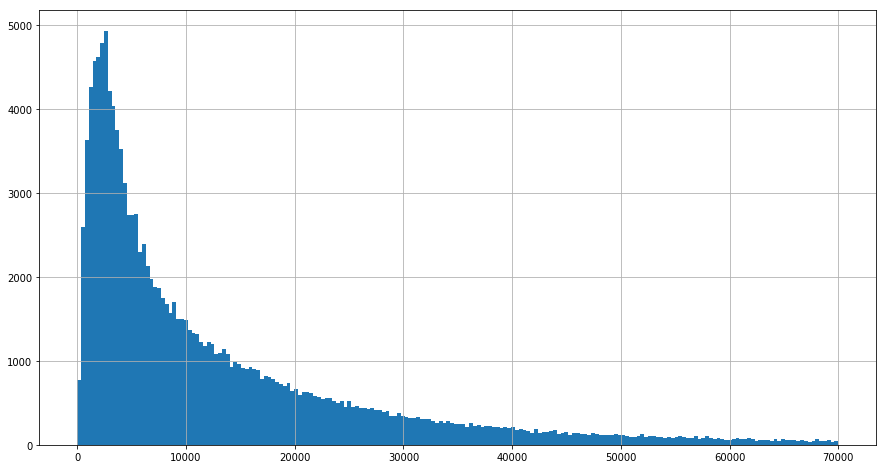

In [17]:
plt.figure(figsize=(15,8))
data.query('70000 > ord_value > 0').ord_value.hist(bins=200)
#data.query('variant == 0 & 50000 > ord_value > 0').ord_value.hist(bins=100)

In [18]:
# Для удобства добавим колонку "конверсия"
data['conversion'] = data['ord_value'].apply(lambda x: 1 if x > 0 else 0)

data.groupby('variant').mean()

,ord_value,conversion
variant,,
0,697.355784,0.041128
1,701.008786,0.042015


(3.5, 5)

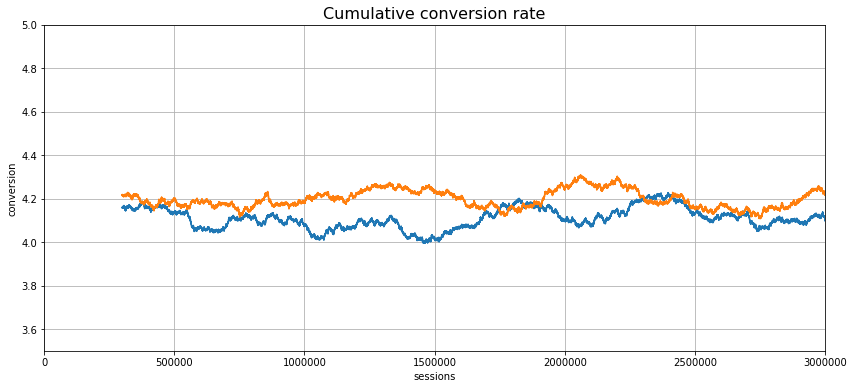

In [27]:
# CR MONITORING BY VARIATIONS

# We can consider row number as time-like value


# Calculating cumulative CR
c0 = 100*data[data['variant'] == 0].rolling(150000).mean()['conversion'][:2000000]
c1 = 100*data[data['variant'] == 1].rolling(150000).mean()['conversion'][:2000000]

# create dashboard
fig, ax = plt.subplots(figsize=(14,6))    
plot(c0)
plot(c1)
title('Cumulative conversion rate', fontdict={'size':16})

xlabel('sessions')
ylabel('conversion')
plt.grid(True)
xlim(0, 3000000)
ylim(3.5,5)

In [13]:
def CR_stat_test(data, k, verbose=False):
    d = data.iloc[:k, :]

    xa = d[d.variant == 0].conversion.sum()
    na = d[d.variant == 0].conversion.count()

    xb = d[d.variant == 1].conversion.sum()
    nb = d[d.variant == 1].conversion.count()

    p = ztest_proportion_two_samples(xa, na, xb, nb, one_sided=False)
    
    return p, k

In [28]:
k = 2000000

d = data.iloc[:k, :]

In [29]:
    xa = d[d.variant == 0].conversion.sum()
    na = d[d.variant == 0].conversion.count()

    xb = d[d.variant == 1].conversion.sum()
    nb = d[d.variant == 1].conversion.count()

    p = ztest_proportion_two_samples(xa, na, xb, nb, one_sided=False, verbose=True)

41020 1001106 42009 998894
z-stat = -3.8313339566141265
p-value = 0.0001274503733863508


In [17]:
CR_stat_test(data, 1500000, verbose=True)

(0.0002441216148818537, 1500000)

In [36]:
pv = [CR_stat_test(data, 10000*i, verbose=False) for i in range(1,150)]

(0, 1)

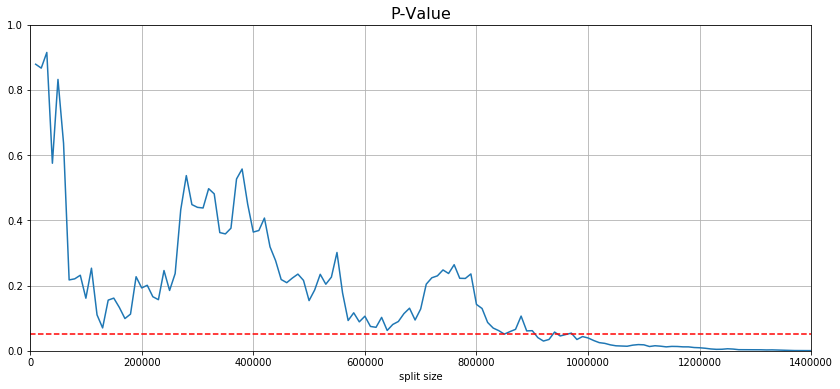

In [37]:
# P-value versus sample size
fig, ax = plt.subplots(figsize=(14,6))    
plot([dot[1] for dot in pv], [dot[0] for dot in pv])
plot([0, 2000000], [0.05, 0.05], color='red', linestyle='dashed')


title('P-Value', fontdict={'size':16})

xlabel('split size')
plt.grid(True)
xlim(0, 1400000)
ylim(0,1)

In [38]:
# using statsmodels
from statsmodels.stats.proportion import proportions_ztest

count = np.array([xa, xb])
nobs = np.array([na, nb])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

 z-stat = -3.8313339566141265 
 p-value = 0.00012745037338645645


In [41]:
data.sort_values(by='ord_value',ascending=False).head(3)

,variant,ord_value,conversion
474002,1,5756398,1
1305494,0,2802137,1
952734,0,1744850,1


In [42]:
from scipy.stats import mannwhitneyu
print(mannwhitneyu.__doc__)


    Compute the Mann-Whitney rank test on samples x and y.

    Parameters
    ----------
    x, y : array_like
        Array of samples, should be one-dimensional.
    use_continuity : bool, optional
            Whether a continuity correction (1/2.) should be taken into
            account. Default is True.
    alternative : None (deprecated), 'less', 'two-sided', or 'greater'
            Whether to get the p-value for the one-sided hypothesis ('less'
            or 'greater') or for the two-sided hypothesis ('two-sided').
            Defaults to None, which results in a p-value half the size of
            the 'two-sided' p-value and a different U statistic. The
            default behavior is not the same as using 'less' or 'greater':
            it only exists for backward compatibility and is deprecated.

    Returns
    -------
    statistic : float
        The Mann-Whitney U statistic, equal to min(U for x, U for y) if
        `alternative` is equal to None (deprecated; exists

In [50]:
#d = data

k = 2000000
d = data.iloc[:k, :]

test = d[d.variant == 1].ord_value
control = d[d.variant == 0].ord_value

mannwhitneyu(test, control, alternative='greater')[1]

6.954858201676086e-05